# Plotting Drake Passage Transport in ACCESS-CM3

This notebook uses the initial spinup simulation of ACCESS-CM3.

In [2]:
#The following cell must be in all notebooks!

In [3]:
#parameters

### USER EDIT start
esm_file='/g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/zv30/non-cmip/ACCESS-CM3/cm3-run-11-08-2025-25km-beta-om3-new-um-params/cm3-demo-datastore/cm3-demo-datastore.json
Plot folder path:  /g/data/tm70/ek4684/access-om3-paper-figs/


In [4]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime


In [5]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [6]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [7]:
umo = datastore.search(variable="umo",).to_dataset_dict( xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks="auto",
        decode_timedelta=True
    )
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id'


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [8]:
key_3dz = [k for k in umo.keys() if ".z_l:" in k][0]
umo_3dz = umo[key_3dz]
del umo  # drop the whole dict
umo = {"3d_z": umo_3dz}  

In [9]:
ds = umo["3d_z"]            

zdim = "z_l" if "z_l" in ds["umo"].dims else "zl"

# Vertically integrate (sum over layers)
umo_2d = ds["umo"].sum(dim=zdim, skipna=True)   # -> (time, yh, xq)

umo_2d.attrs.update(long_name="Ocean Mass X Transport Vertical Sum")

In [10]:
umo_2d

<xarray.DataArray 'umo' (time: 600, yh: 1142, xq: 1440)> Size: 4GB
dask.array<sum-aggregate, shape=(600, 1142, 1440), dtype=float32, chunksize=(4, 470, 592), chunktype=numpy.ndarray>
Coordinates:
  * xq       (xq) float64 12kB -279.8 -279.5 -279.2 -279.0 ... 79.5 79.75 80.0
  * yh       (yh) float64 9kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.95
  * time     (time) datetime64[ns] 5kB 1981-01-16T12:00:00 ... 2030-12-16T12:...
Attributes:
    long_name:  Ocean Mass X Transport Vertical Sum

## Load ACCESS-CM2 data from ACCESS-NRI Catalog

In [11]:
catalog = intake.cat.access_nri

In [12]:
var = catalog.search(variable='tx_trans_int_z',frequency="1mon")

In [13]:
var = catalog['cj877'].search(variable='tx_trans_int_z',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
tx_trans_int_z=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"yh": -1, "xh": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


(-80.0, -40.0)

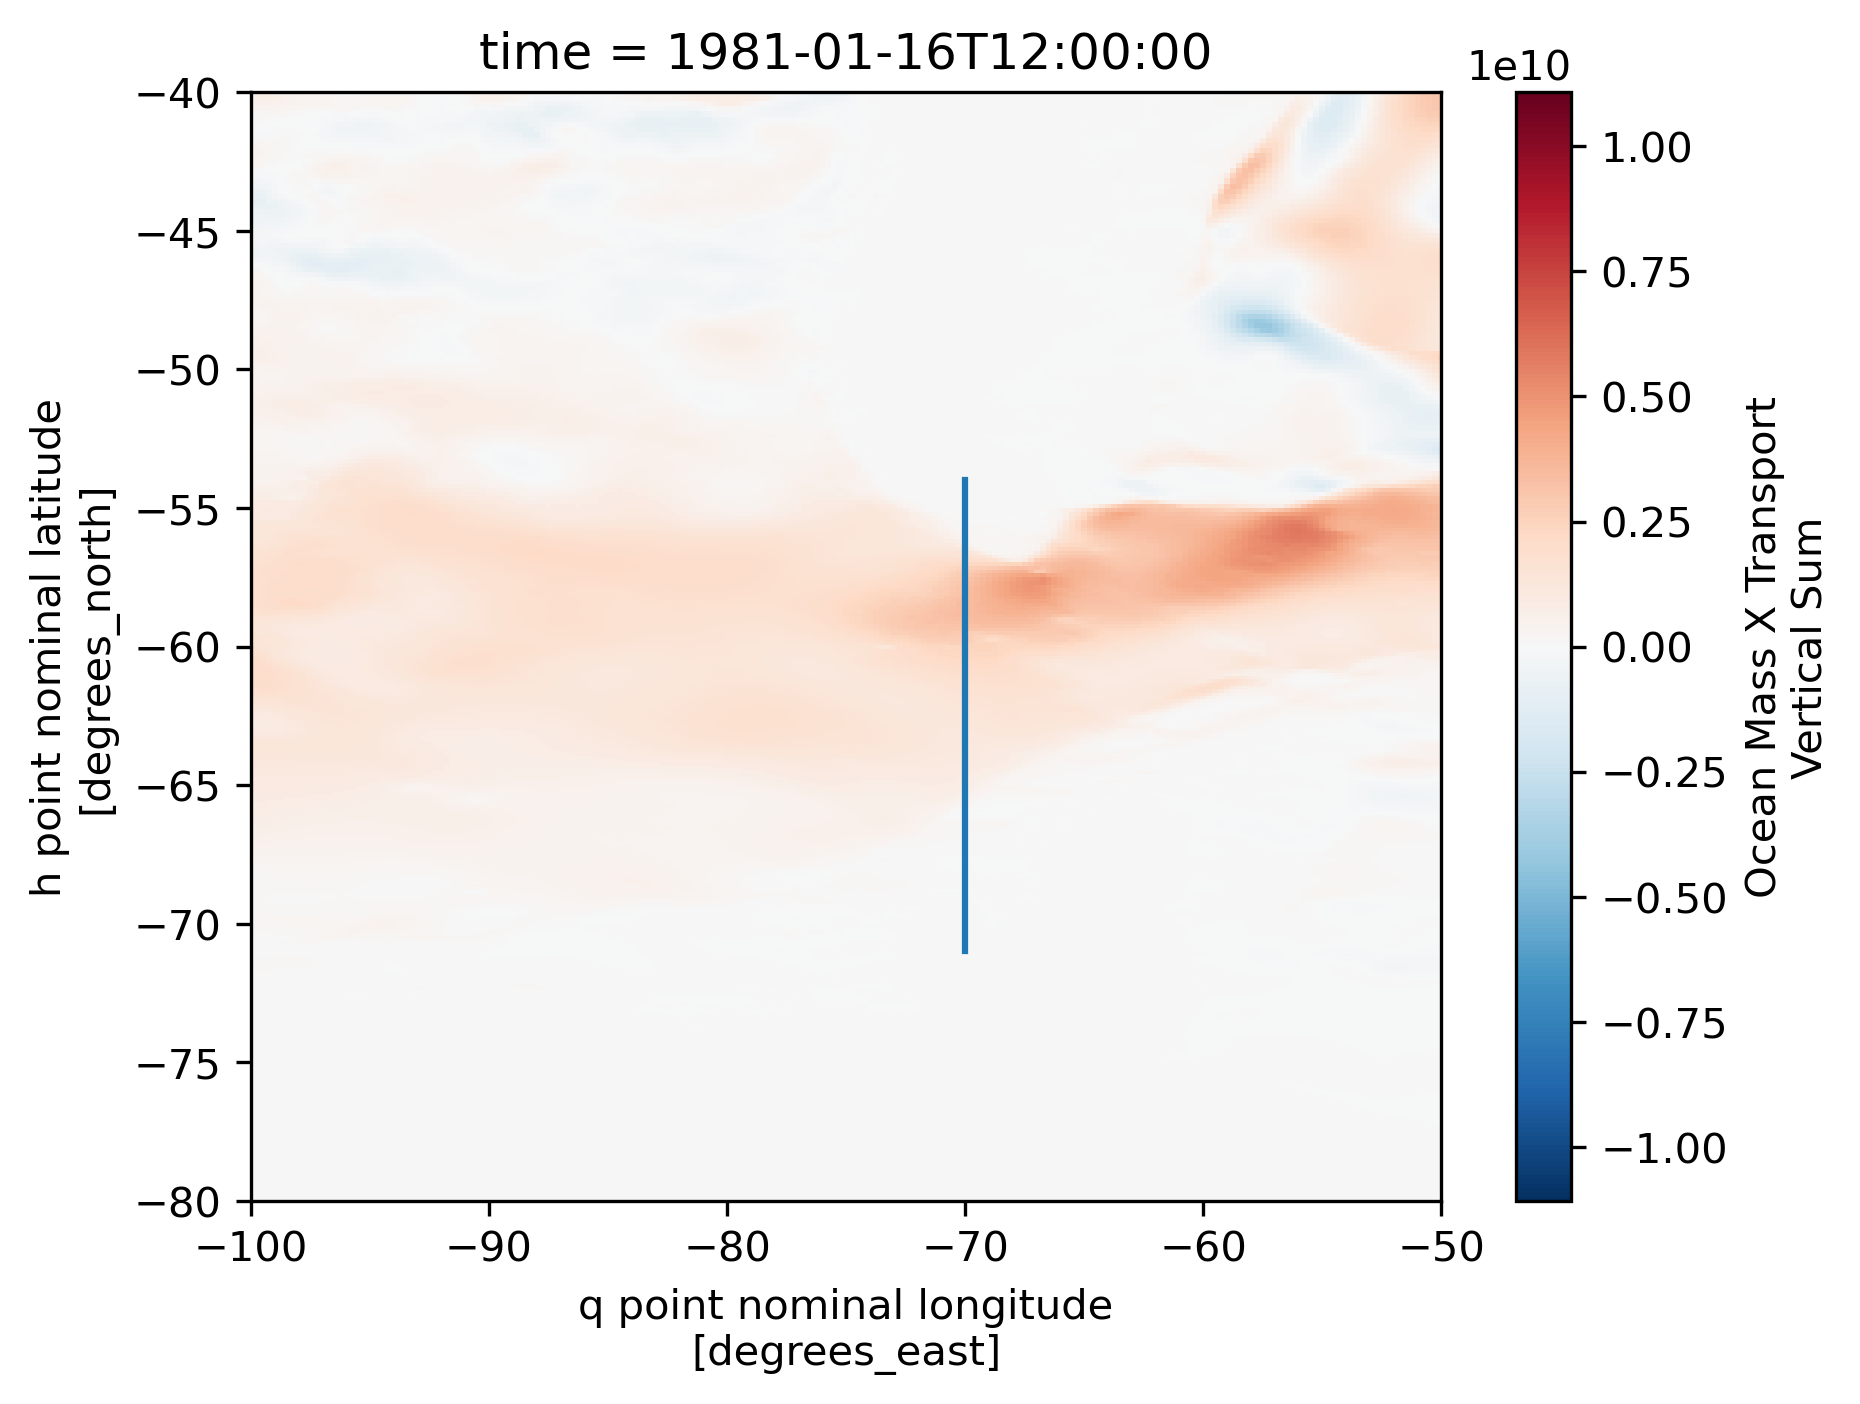

In [14]:
umo_2d.isel(time=0).plot()
plt.plot([-70,-70],[-71,-54])
plt.xlim([-100,-50])
plt.ylim([-80,-40])

## Timeseries of DP Transport at -70°

In [15]:
DP_Trans_CM3 = umo_2d.sel(xq=-70,method='nearest').sel(yh=slice(-71,-54)).sum("yh").load() / 1025 / 1e6

In [16]:
DP_Trans_CM2 = (
    tx_trans_int_z["tx_trans_int_z"]
    .sel(xu_ocean=-70, method="nearest")
    .sel(yt_ocean=slice(-71, -54)).sum("yt_ocean")
    .sel(time=slice(cftime.DatetimeProlepticGregorian(1,1,1), cftime.DatetimeProlepticGregorian(50,12,31))) 
    .chunk({"time": 60})                      
    .compute()
) / 1036 / 1e6

In [19]:
DP_Trans_CM2 = DP_Trans_CM2.convert_calendar(
    "proleptic_gregorian",   # match CM3’s calendar
    use_cftime=True
)

In [21]:
DP_Trans_CM2

<xarray.DataArray 'tx_trans_int_z' (time: 600)> Size: 2kB
array([139.96094, 161.37068, 159.88768, 154.97606, 164.27658, 167.09789,
       172.09276, 168.01659, 165.44044, 158.16054, 159.85783, 152.32812,
       152.26923, 152.45876, 158.78879, 158.83058, 167.4577 , 165.46138,
       165.91177, 164.69841, 164.1536 , 160.30951, 158.49963, 152.17645,
       149.79224, 150.09525, 149.75694, 160.02205, 155.2638 , 161.15503,
       158.65129, 163.60146, 162.40303, 165.97478, 161.79361, 156.52925,
       155.07986, 158.1487 , 162.95598, 161.79314, 167.10115, 158.69693,
       161.9448 , 156.14156, 162.69258, 156.29916, 155.5912 , 148.60771,
       153.4616 , 160.10127, 157.4249 , 170.94469, 174.02286, 168.30388,
       172.48973, 162.17519, 166.63815, 164.15479, 152.76225, 154.83398,
       156.39157, 157.81693, 161.34947, 162.72133, 162.90108, 168.2484 ,
       168.03453, 165.83746, 169.96472, 167.29373, 163.31522, 159.1364 ,
       161.93057, 158.5798 , 161.85889, 172.68521, 168.5992 , 163.70584,
       168.96059, 156.83305, 167.78603, 161.01366, 158.60136, 160.2366 ,
       158.05412, 155.07368, 160.43437, 162.80923, 169.32101, 168.65947,
       162.35078, 164.66562, 166.01494, 165.40175, 156.93738, 159.48834,
       158.78221, 160.50735, 165.49586, 160.65489, 171.4193 , 173.44608,
       167.96925, 167.39111, 171.72102, 171.1552 , 170.78429, 164.89343,
       163.36263, 160.24675, 167.45837, 173.87958, 172.9849 , 173.68674,
       170.35625, 170.44052, 165.57327, 172.72002, 167.31035, 158.38391,
...
       191.85973, 189.85783, 183.11682, 181.68492, 188.41843, 185.38768,
       186.7452 , 180.5572 , 182.04045, 182.14357, 183.33907, 176.3977 ,
       178.26108, 187.9286 , 183.69489, 182.01788, 181.92226, 177.95987,
       176.70222, 180.67908, 182.70415, 185.63753, 178.65756, 188.74013,
       187.86626, 191.12453, 186.20694, 174.08446, 180.25266, 176.46468,
       180.1332 , 177.62424, 183.31937, 184.63013, 187.20596, 187.48593,
       190.57477, 190.60304, 192.8892 , 183.64848, 183.89656, 180.04388,
       184.39256, 182.33139, 182.93161, 182.38086, 181.79175, 182.64705,
       186.37096, 186.67049, 188.25108, 185.85658, 183.37453, 175.37334,
       176.65535, 178.17146, 184.40038, 180.4181 , 187.10414, 182.51427,
       182.49252, 184.08347, 188.05818, 187.31734, 180.6992 , 171.52852,
       165.1504 , 172.9161 , 179.51428, 182.16711, 190.04567, 185.12033,
       185.29897, 187.37637, 187.07628, 188.03989, 184.9764 , 182.85156,
       178.79318, 177.381  , 184.52824, 190.57191, 193.6573 , 184.36115,
       191.5844 , 188.14409, 182.71997, 177.94894, 182.56497, 175.70834,
       174.27592, 181.21927, 187.2073 , 186.78497, 181.84   , 182.38213,
       181.71088, 186.50768, 179.58092, 175.87239, 179.95218, 173.79782,
       177.22029, 186.14548, 188.62056, 185.49135, 176.06418, 182.2688 ,
       178.65947, 183.15927, 191.39798, 191.88513, 182.80577, 176.59   ],
      dtype=float32)
Coordinates:
    xu_ocean  float64 8B -70.0
  * time      (time) object 5kB 0001-01-16 12:00:00 ... 0050-12-16 12:00:00

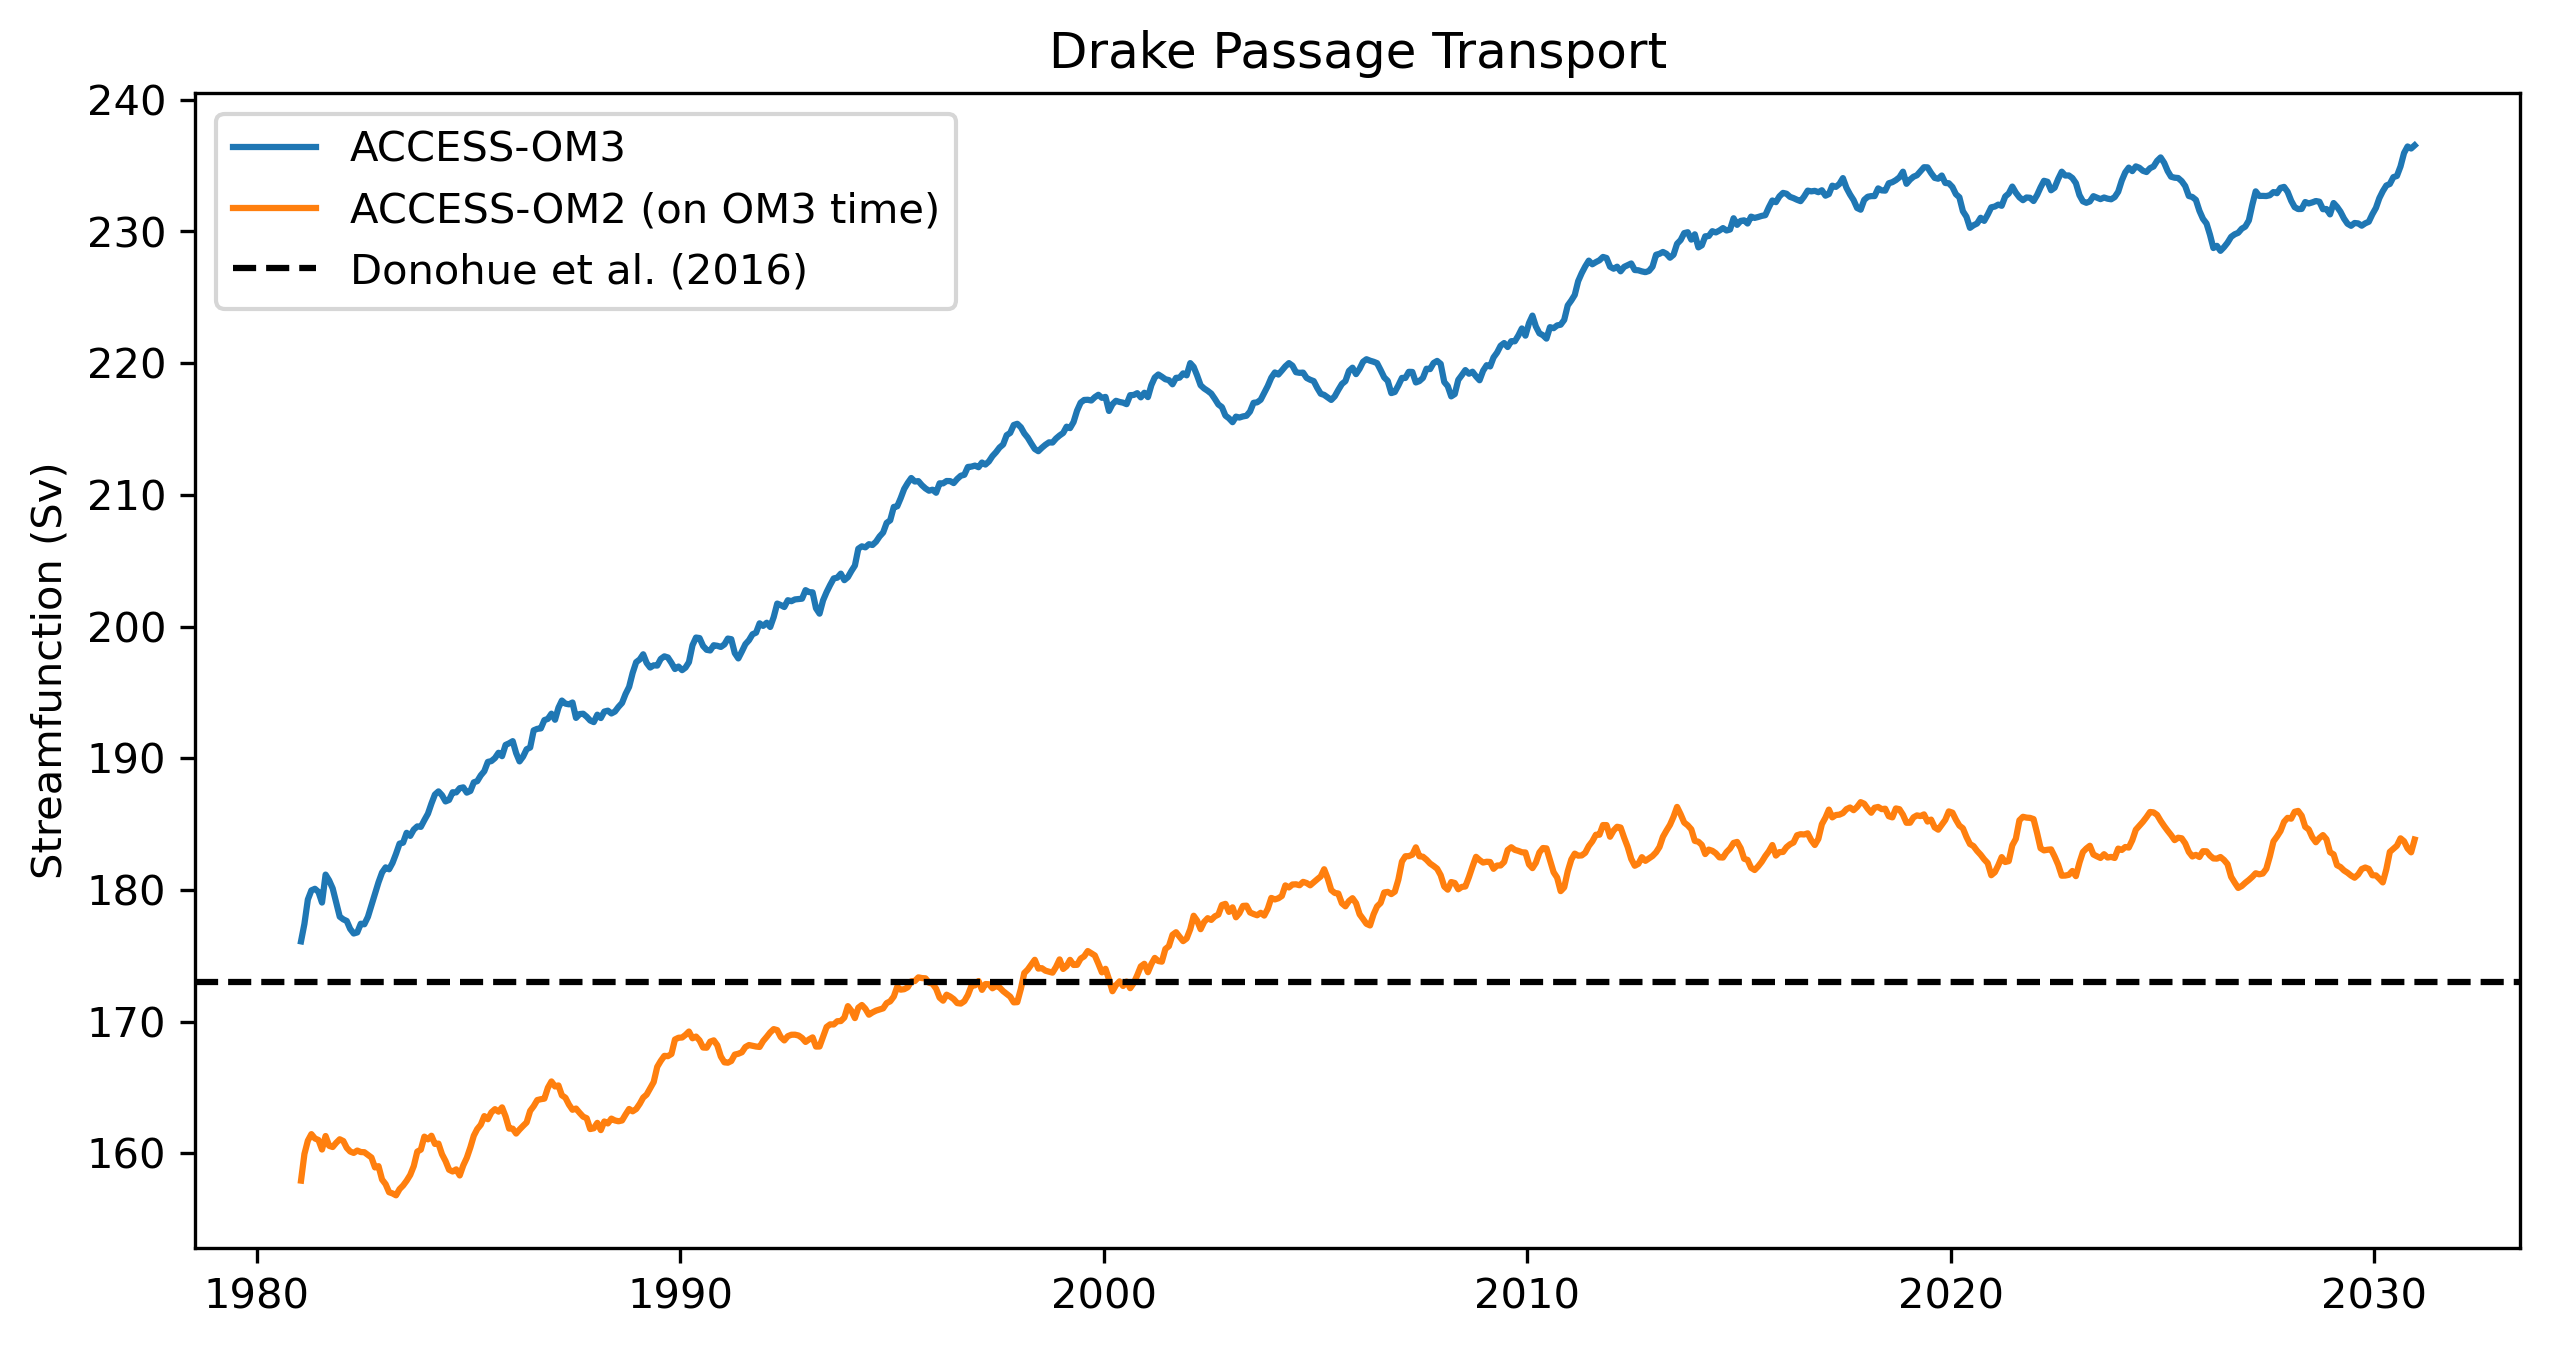

In [22]:
n = min(DP_Trans_CM2.sizes["time"], DP_Trans_CM3.sizes["time"])

# borrow CM3's time axis (cftime) for plotting
t = DP_Trans_CM3.isel(time=slice(0, n)).time.values

y_cm2 = (
    DP_Trans_CM2.isel(time=slice(0, n))
    .rolling(time=12, center=True, min_periods=6).mean()
    .compute().values
)
y_cm3 = (
    DP_Trans_CM3.isel(time=slice(0, n))
    .rolling(time=12, center=True, min_periods=6).mean()
    .compute().values
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t, y_cm3, label="ACCESS-CM3")
ax.plot(t, y_cm2, label="ACCESS-CM2")

ax.axhline(173, linestyle="--", color="k", label="Donohue et al. (2016)")

ax.set_ylabel("Streamfunction (Sv)")
ax.set_title("Drake Passage Transport")
ax.legend()
plt.show()


In [ ]:
client.close()